In [1]:
!pip install --quiet numpy==1.25.2
!pip install --quiet scipy
!pip install --quiet tensorflow_federated

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split

In [2]:
# ---------- Load and Prepare Data ----------
ticker_files = [
    "AAPL_financial_data.csv",
    "AMZN_financial_data.csv",
    "MSFT_financial_data.csv",
    "GOOGL_financial_data.csv",
    "NVDA_financial_data.csv",
    "META_financial_data.csv",
]
sentiment_df = pd.read_csv("sentiment_relevancy_score.csv")
sentiment_features = sentiment_df.iloc[:, [0, 1]]

In [3]:
client_datasets = []
for file in ticker_files:
    df = pd.read_csv(file)
    df = df.drop(df.columns[0], axis=1)  # Drop date column
    input_features = pd.concat([df.iloc[:, :-1], sentiment_features], axis=1)
    labels = df.iloc[:, 1].shift(-1)  # Shift closing value (assumed at col index 1) up by 1
    full_df = input_features.copy()
    full_df["target"] = labels
    full_df.dropna(inplace=True)
    client_datasets.append(full_df)

In [21]:
# ---------- Prepare TFF Datasets ----------
#import standard scaler
from sklearn.preprocessing import StandardScaler
def preprocess(df):
    X = df.iloc[:, :-1].values.astype('float32')
    y = df.iloc[:, -1].values.astype('float32').reshape(-1, 1)  # Keep as 2D


    sc_X = StandardScaler()
    X = sc_X.fit_transform(X)

    sc_y = StandardScaler()
    y = sc_y.fit_transform(y)

    global scaler_y
    scaler_y = sc_y

    # Split maintaining temporal order
    split_idx = int(0.85 * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(5)
    return train_ds, test_ds, sc_y

In [23]:
# Create federated datasets
federated_train_data = []
test_datasets = []
for df in client_datasets:
    train_ds, test_ds, sc_y = preprocess(df)
    federated_train_data.append(train_ds)
    test_datasets.append(test_ds)

In [24]:
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(7,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.GroupNormalization(groups=32),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

In [25]:
# ---------- Wrap Model for TFF ----------
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss = tf.keras.losses.LogCosh(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

In [26]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(

    model_fn=model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.01),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1)
)
print(type(iterative_process))

# ✅ Initialize the state
state = iterative_process.initialize()

# ✅ Run training
for round_num in range(30):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"Round {round_num+1}, Metrics={metrics}")



<class 'tensorflow_federated.python.learning.templates.learning_process.LearningProcess'>
Round 1, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.79436404), ('loss', 0.39238384), ('num_examples', 366), ('num_batches', 78)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.43149966), ('loss', 0.1420214), ('num_examples', 366), ('num_batches', 78)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.36153066), ('loss', 0.102537595), ('num_examples', 366), ('num_batches', 78)]))])), ('aggregator', O

Global Test MAE: 0.2962
Global Test MAPE: 45.26%

Client 0 MAE: 0.2869


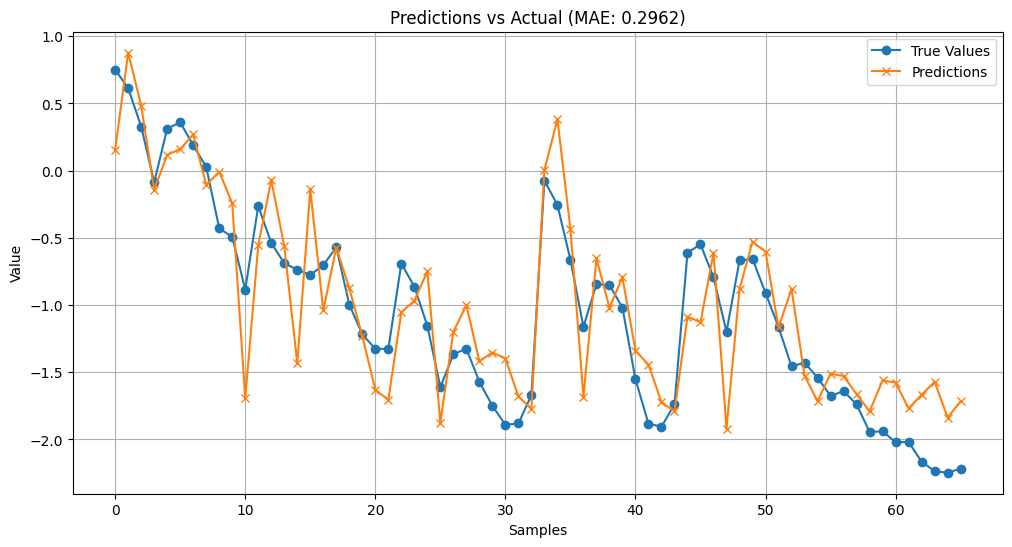

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
# ---------- Evaluation ----------
def evaluate_and_predict(model, test_datasets):
    all_y_true = []
    all_y_pred = []
    client_results = []

    for i, ds in enumerate(test_datasets):
        client_y_true = []
        client_y_pred = []

        for x_batch, y_batch in ds:
            preds = model.predict(x_batch, verbose=0).squeeze()
            y_true = y_batch.numpy().squeeze()

            # Check if y_true is a scalar and convert to a list if necessary
            if y_true.ndim == 0:  # Check if 0-dimensional
                y_true = [y_true]  # Convert to a list with one element

            #Check if preds is a scalar and convert to a list if necessary
            if preds.ndim == 0:
                preds = [preds]

            client_y_true.extend(y_true)
            client_y_pred.extend(preds)

        client_results.append({
            'client_id': i,
            'mae': mean_absolute_error(client_y_true, client_y_pred),
            'predictions': list(zip(client_y_true, client_y_pred))
        })

        all_y_true.extend(client_y_true)
        all_y_pred.extend(client_y_pred)

    mae = mean_absolute_error(all_y_true, all_y_pred)
    mape = 100 * np.mean(np.abs((np.array(all_y_true) - np.array(all_y_pred)) / np.array(all_y_true)))

    return {
        'global_mae': mae,
        'global_mape': mape,
        'per_client_results': client_results,
        'all_predictions': list(zip(all_y_true, all_y_pred))
    }

# Create and evaluate final model
final_model = create_keras_model()
#state.model.assign_weights_to(final_model)
state.global_model_weights.assign_weights_to(final_model)

results = evaluate_and_predict(final_model, test_datasets)

print(f"Global Test MAE: {results['global_mae']:.4f}")
print(f"Global Test MAPE: {results['global_mape']:.2f}%")
print(f"\nClient 0 MAE: {results['per_client_results'][0]['mae']:.4f}")

# Visualize predictions
y_true, y_pred = zip(*results['all_predictions'][:100])
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True Values', marker='o')
plt.plot(y_pred, label='Predictions', marker='x')
plt.title(f"Predictions vs Actual (MAE: {results['global_mae']:.4f})")
plt.xlabel("Samples")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

Global Test MAE: 13.6269
Global Test MAPE: 5.35%

Client 0 MAE: 13.1973


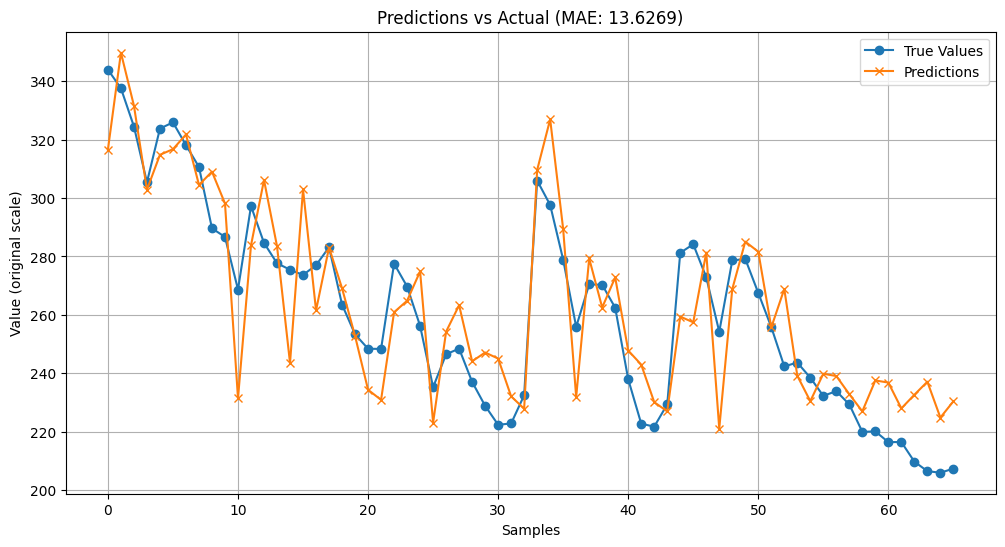

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

def evaluate_and_predict(model, test_datasets, scaler_y):
    all_y_true = []
    all_y_pred = []
    client_results = []

    for i, ds in enumerate(test_datasets):
        client_y_true = []
        client_y_pred = []

        for x_batch, y_batch in ds:
            preds = model.predict(x_batch, verbose=0).squeeze()
            y_true = y_batch.numpy().squeeze()

            # Check if y_true is a scalar and convert to a list if necessary
            if y_true.ndim == 0:  # Check if 0-dimensional
                y_true = [y_true]  # Convert to a list with one element

            # Check if preds is a scalar and convert to a list if necessary
            if preds.ndim == 0:
                preds = [preds]

            client_y_true.extend(y_true)
            client_y_pred.extend(preds)

        # Reverse scaling for client-specific results
        client_y_true_orig = scaler_y.inverse_transform(np.array(client_y_true).reshape(-1, 1)).flatten()
        client_y_pred_orig = scaler_y.inverse_transform(np.array(client_y_pred).reshape(-1, 1)).flatten()

        client_results.append({
            'client_id': i,
            'mae': mean_absolute_error(client_y_true_orig, client_y_pred_orig),
            'predictions': list(zip(client_y_true_orig, client_y_pred_orig))
        })

        all_y_true.extend(client_y_true_orig)
        all_y_pred.extend(client_y_pred_orig)

    mae = mean_absolute_error(all_y_true, all_y_pred)
    mape = 100 * np.mean(np.abs((np.array(all_y_true) - np.array(all_y_pred)) / np.array(all_y_true)))

    return {
        'global_mae': mae,
        'global_mape': mape,
        'per_client_results': client_results,
        'all_predictions': list(zip(all_y_true, all_y_pred))
    }

# Create and evaluate final model
final_model = create_keras_model()
state.global_model_weights.assign_weights_to(final_model)

# Pass the scaler_y to the evaluation function
results = evaluate_and_predict(final_model, test_datasets, scaler_y)

print(f"Global Test MAE: {results['global_mae']:.4f}")
print(f"Global Test MAPE: {results['global_mape']:.2f}%")
print(f"\nClient 0 MAE: {results['per_client_results'][0]['mae']:.4f}")

# Visualize predictions (now in original scale)
y_true, y_pred = zip(*results['all_predictions'][:100])
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True Values', marker='o')
plt.plot(y_pred, label='Predictions', marker='x')
plt.title(f"Predictions vs Actual (MAE: {results['global_mae']:.4f})")
plt.xlabel("Samples")
plt.ylabel("Value (original scale)")
plt.legend()
plt.grid()
plt.show()

Round 1, MAE: 0.4315
Round 2, MAE: 0.3615
Round 3, MAE: 0.3309
Round 4, MAE: 0.3078
Round 5, MAE: 0.2911
Round 6, MAE: 0.2765
Round 7, MAE: 0.2638
Round 8, MAE: 0.2528
Round 9, MAE: 0.2433
Round 10, MAE: 0.2348
Round 11, MAE: 0.2274
Round 12, MAE: 0.2222
Round 13, MAE: 0.2167
Round 14, MAE: 0.2109
Round 15, MAE: 0.2072
Round 16, MAE: 0.2026
Round 17, MAE: 0.1983
Round 18, MAE: 0.1947
Round 19, MAE: 0.1915
Round 20, MAE: 0.1884
Round 21, MAE: 0.1859
Round 22, MAE: 0.1832
Round 23, MAE: 0.1810
Round 24, MAE: 0.1785
Round 25, MAE: 0.1767
Round 26, MAE: 0.1744
Round 27, MAE: 0.1726
Round 28, MAE: 0.1706
Round 29, MAE: 0.1691
Round 30, MAE: 0.1674


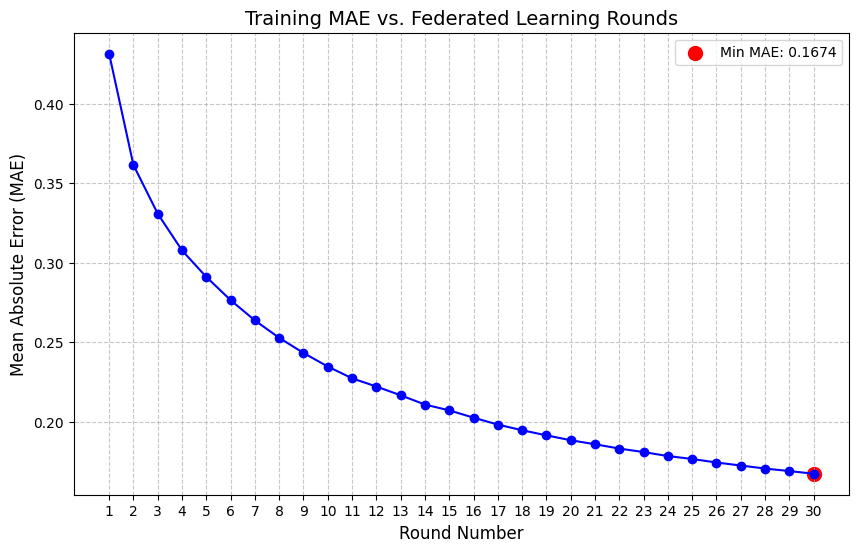

In [35]:
import matplotlib.pyplot as plt

# Initialize lists to store round numbers and MAE values
round_numbers = []
mae_values = []

# Run training and collect metrics
for round_num in range(1, 31):  # Assuming 30 rounds
    state, metrics = iterative_process.next(state, federated_train_data)
    mae = metrics['client_work']['train']['mean_absolute_error']

    round_numbers.append(round_num)
    mae_values.append(mae)

    print(f"Round {round_num}, MAE: {mae:.4f}")

# Plot MAE vs Rounds
plt.figure(figsize=(10, 6))
plt.plot(round_numbers, mae_values, marker='o', linestyle='-', color='b')
plt.title("Training MAE vs. Federated Learning Rounds", fontsize=14)
plt.xlabel("Round Number", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight key points
min_mae = min(mae_values)
min_round = mae_values.index(min_mae) + 1
plt.scatter(min_round, min_mae, color='r', s=100, label=f'Min MAE: {min_mae:.4f}')

plt.legend()
plt.xticks(round_numbers)  # Show all round numbers on x-axis
plt.show()

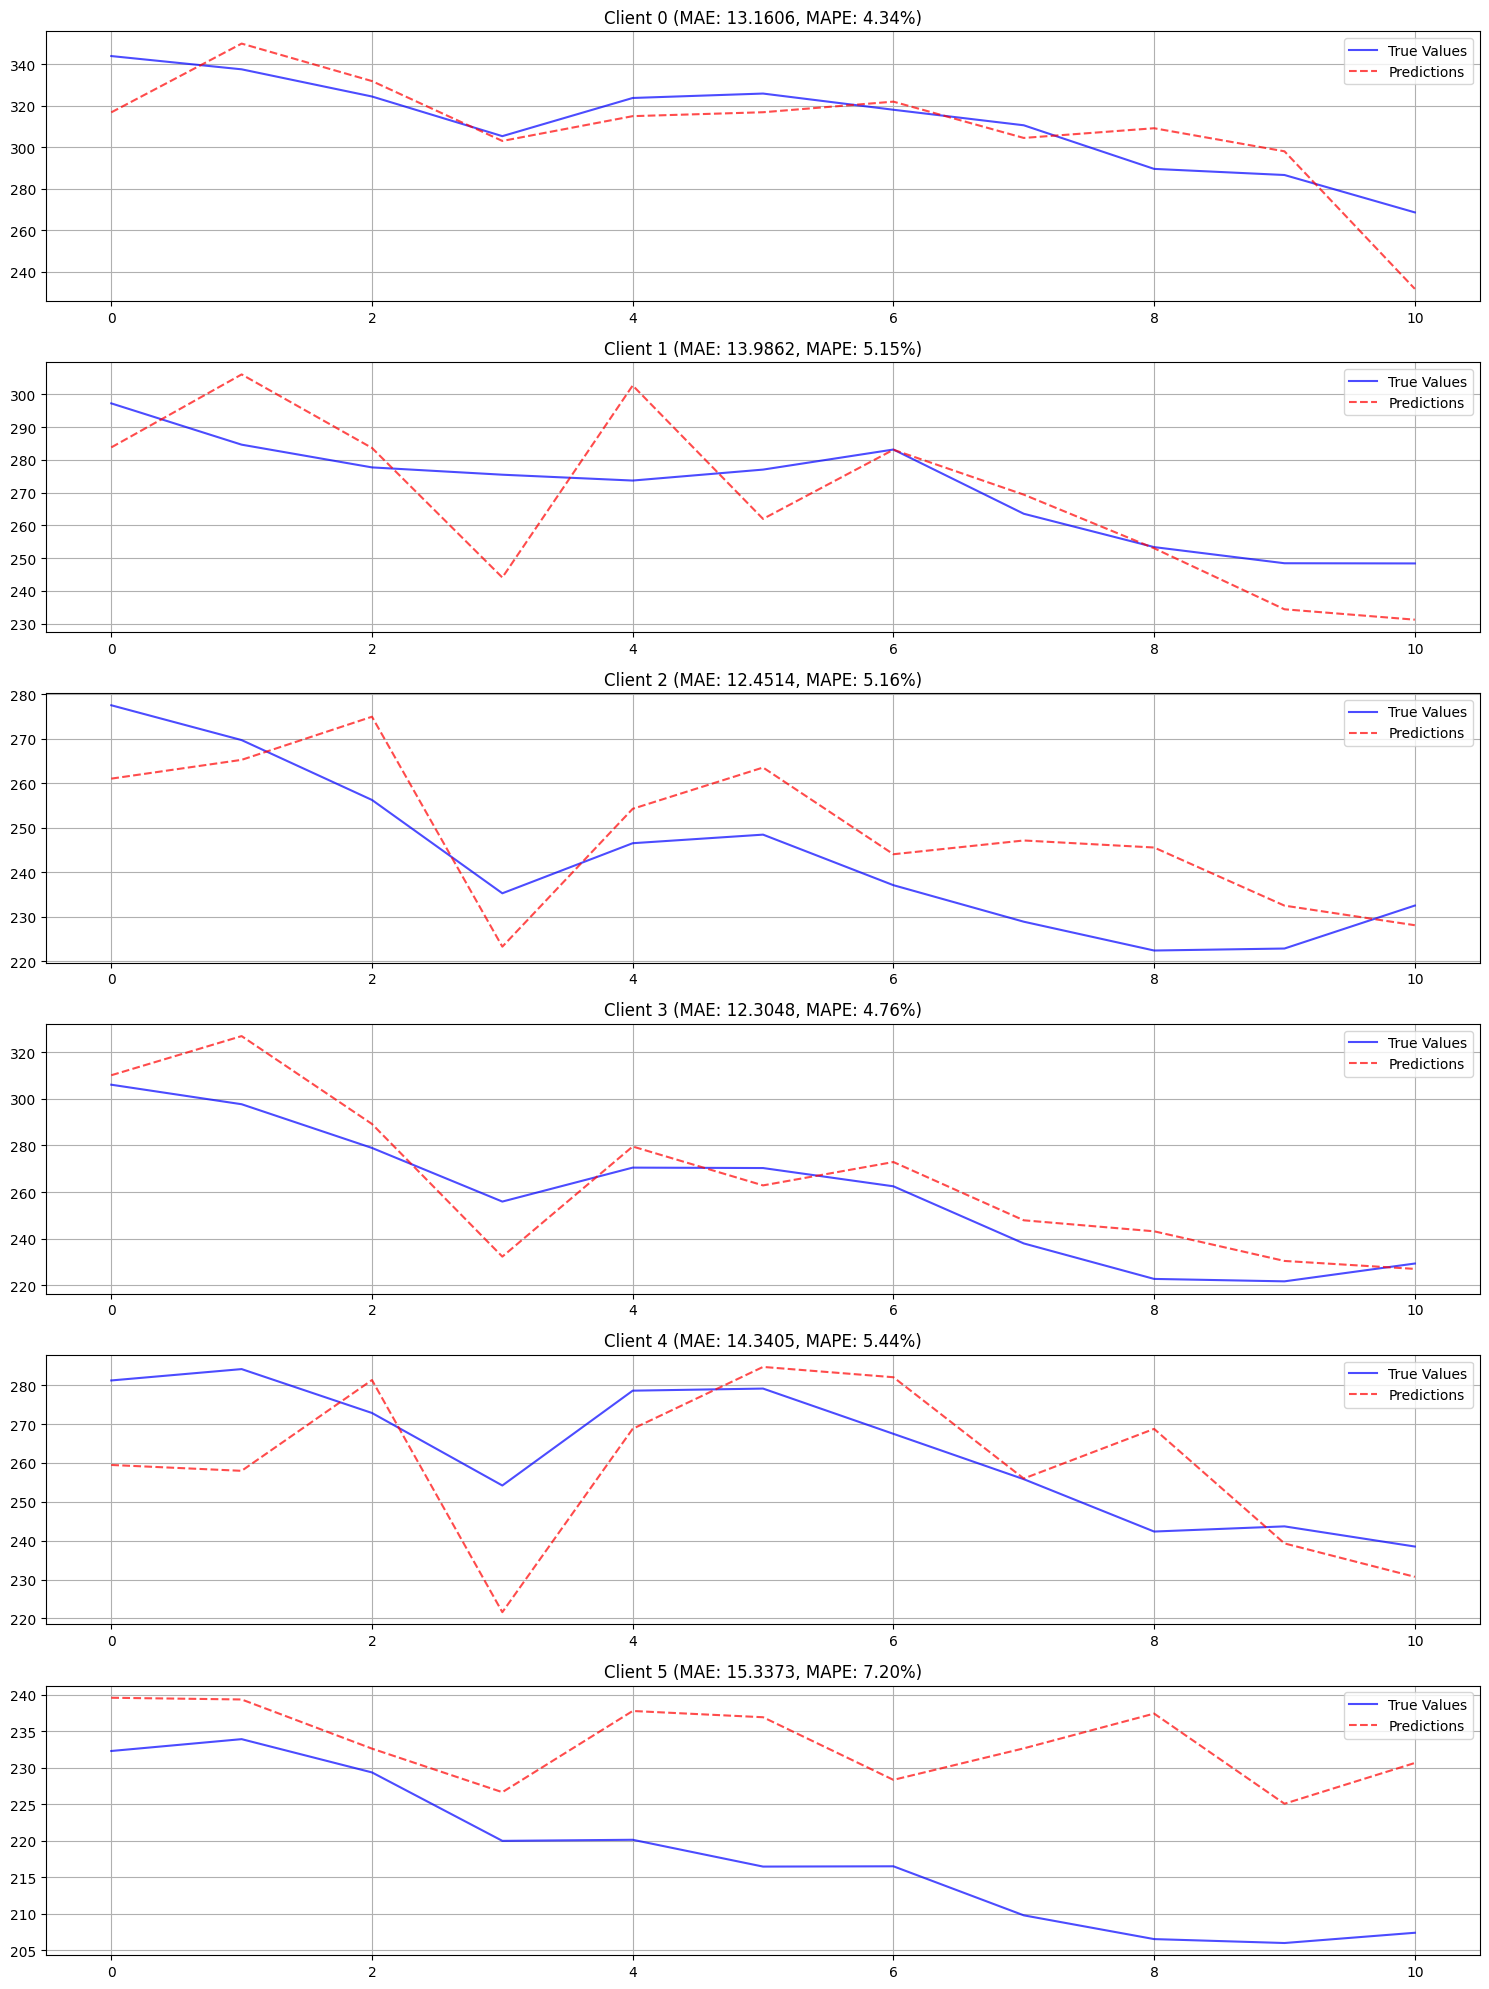


Client-wise Performance Summary:
Client    MAE            MAPE           
0         13.1606        4.34%          
1         13.9862        5.15%          
2         12.4514        5.16%          
3         12.3048        4.76%          
4         14.3405        5.44%          
5         15.3373        7.20%          


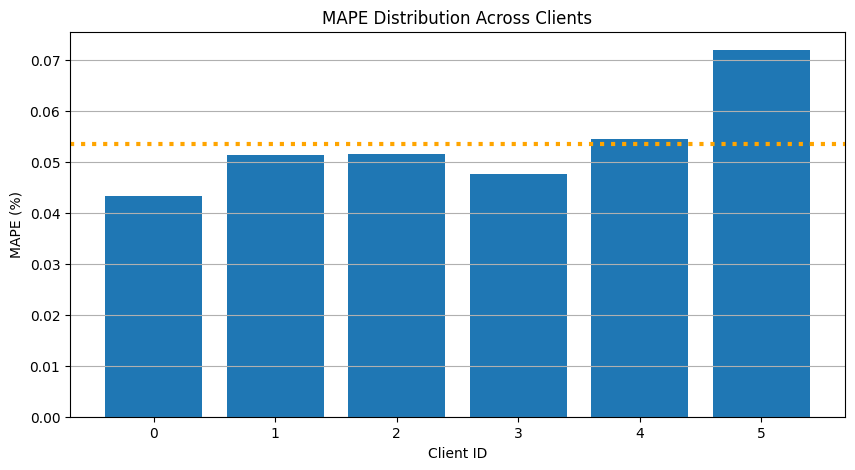

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

def evaluate_and_plot_all_clients(global_model, test_datasets, scaler_y, n_clients=6):
    plt.figure(figsize=(15, 20))

    all_client_maes = []
    all_client_mapes = []

    for client_id in range(n_clients):
        # Extract client test data
        client_ds = test_datasets[client_id]
        y_true_client = []
        y_pred_client = []

        # Make predictions
        for x_batch, y_batch in client_ds:
            preds = global_model.predict(x_batch, verbose=0)
            y_true_client.extend(y_batch.numpy())
            y_pred_client.extend(preds)

        # Convert to numpy arrays
        y_true_client = np.array(y_true_client).reshape(-1, 1)
        y_pred_client = np.array(y_pred_client).reshape(-1, 1)

        # Inverse scaling if needed
        if scaler_y is not None:
            y_true_client = scaler_y.inverse_transform(y_true_client)
            y_pred_client = scaler_y.inverse_transform(y_pred_client)

        # Calculate metrics
        client_mae = mean_absolute_error(y_true_client, y_pred_client)
        client_mape = mean_absolute_percentage_error(y_true_client, y_pred_client)

        all_client_maes.append(client_mae)
        all_client_mapes.append(client_mape)

        # Plot for this client
        plt.subplot(n_clients, 1, client_id + 1)
        plt.plot(y_true_client, label='True Values', color='blue', alpha=0.7)
        plt.plot(y_pred_client, label='Predictions', color='red', alpha=0.7, linestyle='--')
        plt.title(f'Client {client_id} (MAE: {client_mae:.4f}, MAPE: {client_mape:.2%})')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\nClient-wise Performance Summary:")
    print(f"{'Client':<10}{'MAE':<15}{'MAPE':<15}")
    for i, (mae, mape) in enumerate(zip(all_client_maes, all_client_mapes)):
        print(f"{i:<10}{mae:<15.4f}{mape:<15.2%}")

    return all_client_maes, all_client_mapes

# Usage:
final_model = create_keras_model()
state.global_model_weights.assign_weights_to(final_model)

client_maes, client_mapes = evaluate_and_plot_all_clients(
    final_model,
    test_datasets,
    scaler_y=sc_y,  # Pass your y-scaler if used
    n_clients=len(ticker_files)
)

# Plot MAPE distribution across clients
plt.figure(figsize=(10, 5))
plt.bar(range(len(client_mapes)), client_mapes)
plt.title("MAPE Distribution Across Clients")
plt.axhline(y=0.0535, color='orange', linestyle='dotted',linewidth = 3, label='Target MAPE (0.0535)')
plt.xlabel("Client ID")
plt.ylabel("MAPE (%)")
plt.xticks(range(len(client_mapes)))
plt.grid(True, axis='y')
plt.show()